In [1]:
import pickle
import random
import itertools
from itertools import product
from functools import partial
from tqdm import tqdm

import plotly.express as px

import numpy as np
import torch
from torch import Tensor

import einops

from typing import Literal
from jaxtyping import Float

from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens import utils

from ioi_dataset import IOIDataset, format_prompt, make_table

torch.set_grad_enabled(False)

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/jgcarrasco/.virtualenvs/mech_interp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_logit_diff(logits, answer_tokens, average=True):
    """
    Compute the logit difference between the correct answer and the largest logit
    of all the possible incorrect capital letters. This is done for every iteration
    (i.e. each of the three letters of the acronym) and then averaged if desired.
    If `average=False`, then a `Tensor[batch_size, 3]` is returned, containing the
    logit difference at every iteration for every prompt in the batch

    Parameters:
    -----------
    - `logits`: `Tensor[batch_size, seq_len, d_vocab]`
    - `answer_tokens`: Tensor[batch_size, 3]
    """
    # Logits of the correct answers (batch_size, 3)
    correct_logits = logits[:, -3:].gather(-1, answer_tokens[..., None]).squeeze()
    # Retrieve the maximum logit of the possible incorrect answers
    capital_letters_tokens = torch.tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57], dtype=torch.long, device=device)
    batch_size = logits.shape[0]
    capital_letters_tokens_expanded = capital_letters_tokens.expand(batch_size, 3, -1)
    incorrect_capital_letters = capital_letters_tokens_expanded[capital_letters_tokens_expanded != answer_tokens[..., None]].reshape(batch_size, 3, -1)
    incorrect_logits, _ = logits[:, -3:].gather(-1, incorrect_capital_letters).max(-1)
    # Return the mean
    return (correct_logits - incorrect_logits).mean() if average else (correct_logits - incorrect_logits)

In [3]:
model = HookedTransformer.from_pretrained(
    'gpt2-small',
    center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device=device,
)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
with open("acronyms_2_common.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

# take a subset of the dataset (we do this because VRAM limitations)
n_samples = 50
# giga-cursed way of sampling from the dataset
prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

In [5]:
clean_tokens = model.to_tokens(prompts)
answer_tokens = model.to_tokens(acronyms, prepend_bos=False)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logits = model(clean_tokens)

In [6]:
clean_logit_diff = compute_logit_diff(clean_logits, answer_tokens, average=False)[..., -1].mean()
clean_logit_diff.item()

3.3485307693481445

In [7]:
def mean_ablate_head(activations, hook, head_idx, new_cache):
    # activation has shape (batch, pos, head, d_head)
    activations[:, :, head_idx] = new_cache[hook.name][:, :, head_idx].mean(0)[None, ...]
    # activations[:, :, head_idx] = 0.
    return activations

In [8]:
corrupted_logit_diffs = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, n_samples))
with torch.no_grad():
    for layer, head in tqdm(list(product(range(model.cfg.n_layers), range(model.cfg.n_heads)))):
        model.reset_hooks(including_permanent=True)
        hook_fn = partial(mean_ablate_head, head_idx=head, new_cache=clean_cache)
        model.add_hook(utils.get_act_name("result", layer), hook_fn)
        corrupted_logits = model(clean_tokens)
        corrupted_logit_diff = compute_logit_diff(corrupted_logits, answer_tokens, average=False)
        corrupted_logit_diffs[layer, head] = corrupted_logit_diff[..., -1] # take last letter

attribution_score = (corrupted_logit_diffs - clean_logit_diff.cpu()).mean(-1)

100%|██████████| 144/144 [00:15<00:00,  9.48it/s]


In [9]:
px.imshow(attribution_score, title="Attribution score for attention heads (mean-ablation)", labels={"x": "Head", "y": "Layer"}, width=500, height=500, color_continuous_midpoint=0.0, color_continuous_scale="RdBu")

In [10]:
def sort_Nd_tensor(tensor, descending=False):
    i = torch.sort(tensor.flatten(), descending=descending).indices
    return np.array(np.unravel_index(utils.to_numpy(i), tensor.shape)).T.tolist()

# Replicate result from Acronyms Paper

In [11]:
ordered_heads = sort_Nd_tensor(attribution_score, descending=True)

with open("ordered_heads.pkl", "wb") as handle:
    pickle.dump(ordered_heads, handle)

In [ ]:
circuit_heads = [[], [8, 11], [9, 9], [10, 10], [11, 4], [5, 8], [4, 11], [2, 2], [1, 0]]

[list(reversed(ordered_heads)).index(head) for head in circuit_heads[1:]]

[0, 142, 1, 4, 49, 140, 7, 3]

In [ ]:
circuit_heads = [[], [8, 11], [9, 9], [10, 10], [11, 4], [5, 8], [4, 11], [2, 2], [1, 0]]
#circuit_heads = sort_Nd_tensor(attribution_score, descending=False)

circuit_heads_i = []
logit_diffs = []
std_logit_diffs = []

for circuit_head in circuit_heads:
    circuit_heads_i.append(circuit_head)
    heads_to_patch = [[a, b] for a, b in itertools.product(range(0, model.cfg.n_layers), range(model.cfg.n_heads)) if [a, b] not in circuit_heads_i]

    model.reset_hooks(including_permanent=True)
    for layer_i, head_i in heads_to_patch:
        hook_fn = partial(mean_ablate_head, head_idx=head_i, new_cache=clean_cache)
        model.add_hook(utils.get_act_name("result", layer_i), hook_fn)
    circuit_logits = model(clean_tokens)
    model.reset_hooks(including_permanent=True)

    logit_diff = compute_logit_diff(circuit_logits, answer_tokens, average=False)
    av_logit_diff = logit_diff[..., -1].mean(0)
    std_logit_diff = logit_diff[..., -1].std(0)
    logit_diffs.append(av_logit_diff)
    std_logit_diffs.append(std_logit_diff)
logit_diffs = torch.stack(logit_diffs, dim=0)
std_logit_diffs = torch.stack(std_logit_diffs, dim=0)

In [ ]:
labels = ["None"] + [f"{layer}.{head}" for layer, head in circuit_heads[1:]]

In [ ]:
fig = px.line(x = labels, y=logit_diffs.cpu().numpy(), error_y=std_logit_diffs.cpu().numpy())
fig.add_hline(y=clean_logit_diff.item(), line_width=1.5, line_dash="dash", line_color="black")
fig.show()

We have replicated the result from the acronyms paper: first, we ablate every attention head by replacing the output of each head with its average output across the dataset. As expected, we get a bad result (-1 logit diff). Then, we iteratively add components of the circuit, the performance is recovered until we reach the baseline. (NOTE: Expect the error bars to be larger when working with a small sample).

# Complete Mean-ablation experiment
Previous to the sanity check above, we computed the attribution score of each head (i.e. a higher score means that the head is not relevant/contributes positively to the performance on the specific task when mean-ablated). Hence, if I sort by attribution score and iteratively ablate the heads from least to most relevant, I expect the performance to maintain until I start to remove relevant components of the circuit. (i.e. I expect a flat line which then drops suddenly)

In [15]:
circuit_heads = sort_Nd_tensor(attribution_score, descending=True)

heads_to_patch = []
logit_diffs = []
std_logit_diffs = []

for circuit_head in circuit_heads:
    heads_to_patch.append(circuit_head)
    model.reset_hooks(including_permanent=True)
    for layer_i, head_i in heads_to_patch:
        hook_fn = partial(mean_ablate_head, head_idx=head_i, new_cache=clean_cache)
        model.add_hook(utils.get_act_name("result", layer_i), hook_fn)
    circuit_logits = model(clean_tokens)
    model.reset_hooks(including_permanent=True)

    logit_diff = compute_logit_diff(circuit_logits, answer_tokens, average=False)
    av_logit_diff = logit_diff[..., -1].mean(0)
    std_logit_diff = logit_diff[..., -1].std(0)
    logit_diffs.append(av_logit_diff)
    std_logit_diffs.append(std_logit_diff)
logit_diffs = torch.stack(logit_diffs, dim=0)
std_logit_diffs = torch.stack(std_logit_diffs, dim=0)

In [16]:
labels = [f"{layer}.{head}" for layer, head in circuit_heads]
fig = px.line(x = labels, y=logit_diffs.cpu().numpy(), error_y=std_logit_diffs.cpu().numpy())
fig.add_hline(y=clean_logit_diff.item(), line_width=1.5, line_dash="dash", line_color="black")
fig.show()

Check: If we iteratively ablate heads from least/most important, we even get an increase in logit difference, until we arrive to the heads of the circuit and then performance drops suddenly. This implies that we can prune around ~90% of the heads and still get good performance on the task of study! 

When zero-ablating instead of mean-ablating, the results are much more noisy. This is expected, as zero-ablating is much more aggressive and may send components off-distribution. It is also funny to see that the performance often improves. 
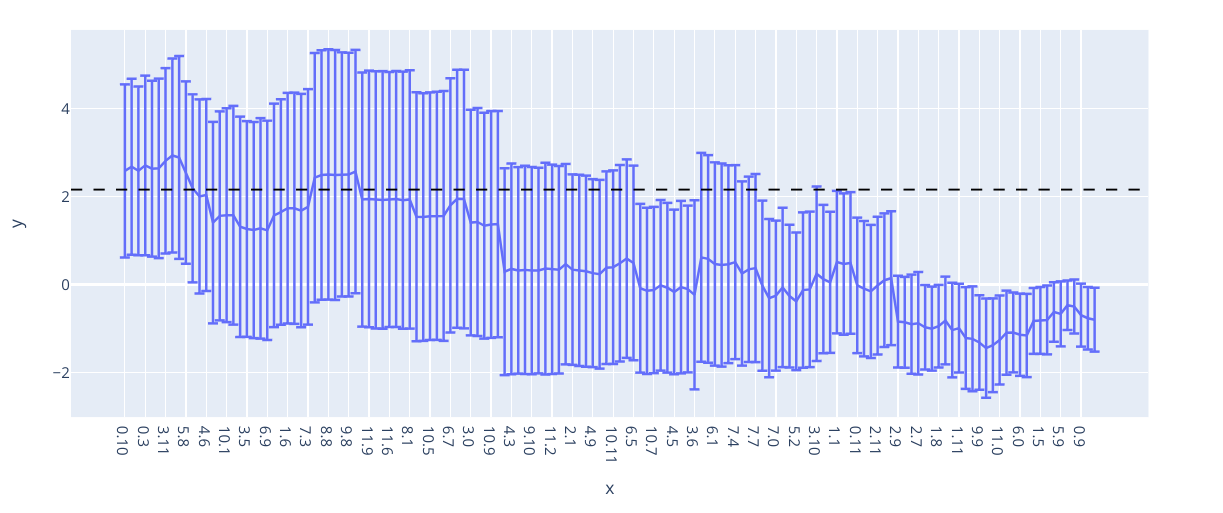
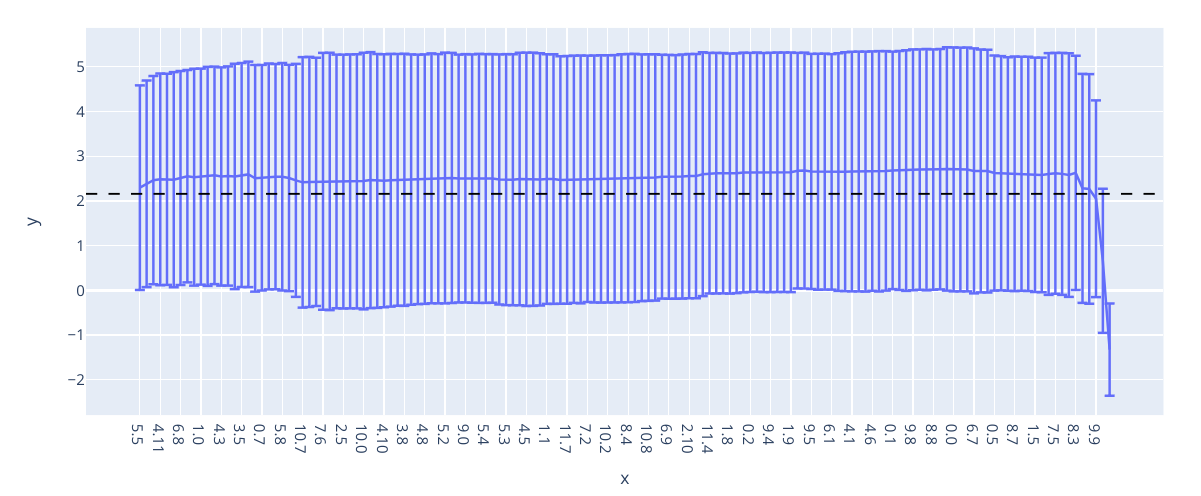

# Mean-ablating MLPs

In [13]:
def mean_ablate_MLP(activations, hook, new_cache):
    # activation has shape (batch, pos, head, d_head)
    activations = new_cache[hook.name].mean(0)[None, ...]
    return activations

In [14]:
corrupted_logit_diffs = torch.zeros((model.cfg.n_layers, n_samples))
with torch.no_grad():
    for layer in tqdm(list(range(model.cfg.n_layers))):
        model.reset_hooks(including_permanent=True)
        hook_fn = partial(mean_ablate_MLP, new_cache=clean_cache)
        model.add_hook(utils.get_act_name("mlp_out", layer), hook_fn)
        corrupted_logits = model(clean_tokens)
        corrupted_logit_diff = compute_logit_diff(corrupted_logits, answer_tokens, average=False)
        corrupted_logit_diffs[layer] = corrupted_logit_diff[..., -1] # take last letter

attribution_score = (corrupted_logit_diffs - clean_logit_diff.cpu()).mean(-1)

100%|██████████| 12/12 [00:01<00:00, 10.26it/s]


In [15]:
px.imshow(attribution_score.unsqueeze(0), title="Attribution score for MLPs (mean-ablation)", labels={"x": "Layer"}, width=1000, height=400, color_continuous_midpoint=0.0, color_continuous_scale="RdBu")

Mean-ablating the MLP of layer 0 has a big impact on the performance. One of the hypothesis for this is that, as the embedding/unembedding weights are tied, the model probably uses this MLP to "store" the differences. Layers 1-7 don't matter, and layers 8-11 slightly decrease the performance. Hence, I think that MLPs of layers 1-7 could be completely ablated (just replacing them by a bias term) and the performance could be preserved for the specific task. Notice that we can drop 50% of the parameters!

In [16]:
sorted_mlps = torch.sort(attribution_score, descending=True).indices

mlps_to_patch = []
logit_diffs = []
std_logit_diffs = []

for mlp in sorted_mlps:
    mlps_to_patch.append(mlp)
    model.reset_hooks(including_permanent=True)
    for layer_i in mlps_to_patch:
        hook_fn = partial(mean_ablate_MLP, new_cache=clean_cache)
        model.add_hook(utils.get_act_name("mlp_out", layer_i), hook_fn)
    ablated_logits = model(clean_tokens)
    model.reset_hooks(including_permanent=True)

    logit_diff = compute_logit_diff(ablated_logits, answer_tokens, average=False)
    av_logit_diff = logit_diff[..., -1].mean(0)
    std_logit_diff = logit_diff[..., -1].std(0)
    logit_diffs.append(av_logit_diff)
    std_logit_diffs.append(std_logit_diff)
logit_diffs = torch.stack(logit_diffs, dim=0)
std_logit_diffs = torch.stack(std_logit_diffs, dim=0)

In [17]:
labels = [str(x.item()) for x in sorted_mlps]
fig = px.line(x = labels, y=logit_diffs.cpu().numpy(), error_y=std_logit_diffs.cpu().numpy())
fig.add_hline(y=clean_logit_diff.item(), line_width=1.5, line_dash="dash", line_color="black")
fig.show()

We can ablate up to 5 MLPs without noticing a drop in performance (in fact, it even slightly increases)! This implies that we can drop quite a lot of parameters. Now, let's try to ablate both MLPs and attention layers. We will repeat the above experiment, but also mean-ablating all heads except the most important four:

In [26]:
with open("ordered_heads.pkl", "rb") as handle:
    ordered_heads = pickle.load(handle)
heads_to_patch = ordered_heads[:-10]

In [27]:
sorted_mlps = torch.sort(attribution_score, descending=True).indices

mlps_to_patch = []
logit_diffs = []
std_logit_diffs = []

for mlp in sorted_mlps:
    mlps_to_patch.append(mlp)
    model.reset_hooks(including_permanent=True)
    for layer_i in mlps_to_patch:
        hook_fn = partial(mean_ablate_MLP, new_cache=clean_cache)
        model.add_hook(utils.get_act_name("mlp_out", layer_i), hook_fn)
    for layer_i, head_i in heads_to_patch:
        hook_fn = partial(mean_ablate_head, head_idx=head_i, new_cache=clean_cache)
        model.add_hook(utils.get_act_name("result", layer_i), hook_fn)
    ablated_logits = model(clean_tokens)
    model.reset_hooks(including_permanent=True)

    logit_diff = compute_logit_diff(ablated_logits, answer_tokens, average=False)
    av_logit_diff = logit_diff[..., -1].mean(0)
    std_logit_diff = logit_diff[..., -1].std(0)
    logit_diffs.append(av_logit_diff)
    std_logit_diffs.append(std_logit_diff)
logit_diffs = torch.stack(logit_diffs, dim=0)
std_logit_diffs = torch.stack(std_logit_diffs, dim=0)

In [28]:
labels = [str(x.item()) for x in sorted_mlps]
fig = px.line(x = labels, y=logit_diffs.cpu().numpy(), error_y=std_logit_diffs.cpu().numpy())
fig.add_hline(y=clean_logit_diff.item(), line_width=1.5, line_dash="dash", line_color="black")
fig.show()